In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from sklearn.metrics import f1_score, confusion_matrix, classification_report


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import os

print(os.listdir("/content/drive/MyDrive"))


['Colab Notebooks', 'Copy of Built With Science Moderate Workout Tracker.gsheet', 'Saurabh Deutsch.docx', 'Google Earth', 'Copy of Template_Bachelor_Master_EN.docx', 'Copy of Template_Bachelor_Master_EN.gdoc', 'Knee_OA_Project']


In [9]:
print(os.listdir("/content/drive/MyDrive/Knee_OA_Project"))


['archive (10).zip']


In [10]:
import zipfile

zip_path = "/content/drive/MyDrive/Knee_OA_Project/archive (10).zip"
extract_dir = "/content/kneeoa_data"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

print("Extracted!")


Extracted!


In [11]:
from pathlib import Path

DATA_DIR = Path("/content/kneeoa_data")

print(DATA_DIR.exists())
print([p.name for p in DATA_DIR.iterdir()])


True
['train', 'test', 'val', 'auto_test']


In [12]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
splits = ["train", "val", "test"]
rows = []

for split in splits:
    split_dir = DATA_DIR / split
    for label_dir in split_dir.iterdir():
        if label_dir.is_dir():
            label = int(label_dir.name)
            for img_path in label_dir.rglob("*"):
                if img_path.suffix.lower() in IMG_EXTS:
                    rows.append({"path": str(img_path), "label": label, "split": split})

df = pd.DataFrame(rows)
print("Total images:", len(df))
df.head()


Total images: 8260


,path,label,split
0,/content/kneeoa_data/train/4/9287216R.png,4,train
1,/content/kneeoa_data/train/4/9581915L.png,4,train
2,/content/kneeoa_data/train/4/9438523R.png,4,train
3,/content/kneeoa_data/train/4/9373191L.png,4,train
4,/content/kneeoa_data/train/4/9910391R.png,4,train


In [13]:
counts = df.groupby(["split", "label"]).size().unstack(fill_value=0)
counts


label,0,1,2,3,4
split,,,,,
test,639,296,447,223,51
train,2286,1046,1516,757,173
val,328,153,212,106,27


In [14]:
train_df = df[df["split"]=="train"].reset_index(drop=True)
val_df   = df[df["split"]=="val"].reset_index(drop=True)
test_df  = df[df["split"]=="test"].reset_index(drop=True)

print(len(train_df), len(val_df), len(test_df))


5778 826 1656


In [15]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


In [16]:
class KneeOADataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("L")
        y = int(row["label"])
        if self.transform:
            img = self.transform(img)
        return img, y


In [17]:
BATCH_SIZE = 32

train_loader = DataLoader(KneeOADataset(train_df, train_tfms), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(KneeOADataset(val_df, eval_tfms), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(KneeOADataset(test_df, eval_tfms), batch_size=BATCH_SIZE, shuffle=False)


In [18]:
next(iter(train_loader))[0].shape


torch.Size([32, 3, 224, 224])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# class weights from TRAIN split
label_counts = train_df["label"].value_counts().sort_index()
counts = label_counts.values.astype(np.float32)

class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Train label counts:\n", label_counts)
print("Class weights:", class_weights)


Device: cuda
Train label counts:
 label
0    2286
1    1046
2    1516
3     757
4     173
Name: count, dtype: int64
Class weights: tensor([0.2389, 0.5222, 0.3603, 0.7215, 3.1571], device='cuda:0')


In [20]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 5)  # KL 0-4
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [21]:
from sklearn.metrics import f1_score

def run_one_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    all_preds, all_labels = [], []
    running_loss = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(y.detach().cpu().numpy().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, f1, all_labels, all_preds


In [22]:
EPOCHS = 8
best_f1 = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, tr_f1, _, _ = run_one_epoch(model, train_loader, train=True)
    va_loss, va_acc, va_f1, va_y, va_p = run_one_epoch(model, val_loader, train=False)

    scheduler.step(va_f1)

    history.append([epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1])

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save(model.state_dict(), "resnet50_best.pt")
        print("✅ Saved best model: resnet50_best.pt")


Epoch 01 | train loss 1.1696 acc 0.4489 f1 0.4419 || val loss 1.1146 acc 0.5387 f1 0.4517
✅ Saved best model: resnet50_best.pt
Epoch 02 | train loss 0.8635 acc 0.5749 f1 0.6034 || val loss 1.0063 acc 0.5811 f1 0.5270
✅ Saved best model: resnet50_best.pt
Epoch 03 | train loss 0.7879 acc 0.6236 f1 0.6467 || val loss 1.2114 acc 0.5012 f1 0.5463
✅ Saved best model: resnet50_best.pt
Epoch 04 | train loss 0.7280 acc 0.6433 f1 0.6722 || val loss 0.9032 acc 0.6150 f1 0.6217
✅ Saved best model: resnet50_best.pt
Epoch 05 | train loss 0.6869 acc 0.6509 f1 0.6844 || val loss 0.8851 acc 0.6065 f1 0.6242
✅ Saved best model: resnet50_best.pt
Epoch 06 | train loss 0.6850 acc 0.6649 f1 0.6893 || val loss 0.8825 acc 0.6223 f1 0.6279
✅ Saved best model: resnet50_best.pt
Epoch 07 | train loss 0.6492 acc 0.6843 f1 0.7081 || val loss 0.8739 acc 0.6634 f1 0.6483
✅ Saved best model: resnet50_best.pt
Epoch 08 | train loss 0.6462 acc 0.6736 f1 0.7051 || val loss 0.8647 acc 0.6489 f1 0.6374


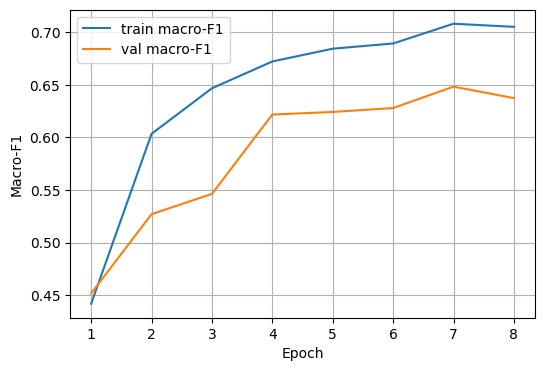

,epoch,tr_loss,tr_acc,tr_f1,va_loss,va_acc,va_f1
0,1,1.169563,0.448944,0.441907,1.114585,0.538741,0.451682
1,2,0.863544,0.574939,0.603425,1.006264,0.581114,0.527043
2,3,0.787901,0.623572,0.646728,1.211367,0.501211,0.546315
3,4,0.727975,0.643302,0.672216,0.903245,0.615012,0.621742
4,5,0.686938,0.650917,0.684364,0.885117,0.606538,0.624221
5,6,0.685028,0.664936,0.689314,0.882460,0.622276,0.627940
6,7,0.649215,0.684320,0.708092,0.873949,0.663438,0.648267
7,8,0.646159,0.673589,0.705138,0.864721,0.648910,0.637379


In [23]:
hist = pd.DataFrame(history, columns=["epoch","tr_loss","tr_acc","tr_f1","va_loss","va_acc","va_f1"])

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["tr_f1"], label="train macro-F1")
plt.plot(hist["epoch"], hist["va_f1"], label="val macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.legend()
plt.grid(True)
plt.show()

hist


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

model.load_state_dict(torch.load("resnet50_best.pt", map_location=device))
model.eval()

te_loss, te_acc, te_f1, te_y, te_p = run_one_epoch(model, test_loader, train=False)

print("TEST loss:", te_loss)
print("TEST acc :", te_acc)
print("TEST macro-F1:", te_f1)

print("\nClassification report:\n")
print(classification_report(te_y, te_p, digits=4))

cm = confusion_matrix(te_y, te_p)
cm


TEST loss: 0.8000929788978779
TEST acc : 0.6757246376811594
TEST macro-F1: 0.6607356036372976

Classification report:

              precision    recall  f1-score   support

           0     0.6760    0.9437    0.7877       639
           1     0.3390    0.2027    0.2537       296
           2     0.7778    0.5011    0.6095       447
           3     0.7500    0.8610    0.8017       223
           4     0.9302    0.7843    0.8511        51

    accuracy                         0.6757      1656
   macro avg     0.6946    0.6586    0.6607      1656
weighted avg     0.6610    0.6757    0.6480      1656



array([[603,  25,  10,   1,   0],
       [199,  60,  32,   5,   0],
       [ 88,  88, 224,  47,   0],
       [  2,   4,  22, 192,   3],
       [  0,   0,   0,  11,  40]])

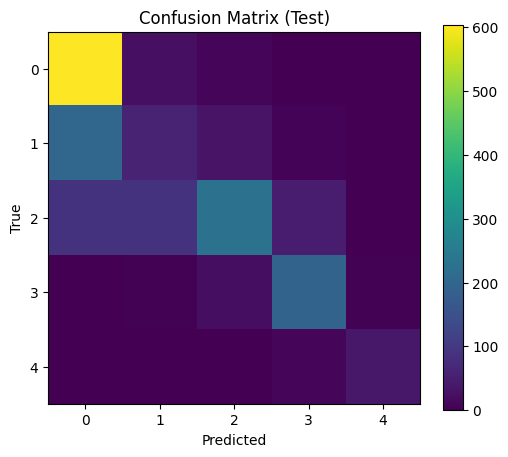

In [25]:
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()
